In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## **The inputs of our System**

In [ ]:
#tragectory length
TLen = 100
N=4
#In each step we have four variables (X , Y, X', Y') i.e (postion x, postion y, speed x, speed y)
Model_Est = np.zeros((4,TLen))
Obs = np.zeros((4,TLen))

#Initial values for (X , Y, X', Y')
Init = np.array([0.6,0.2,2,0.75])

#The error (variance)of the model
ModelVar = 0.2

#The error (variance) of the observation i.e measurement
ObsVar = 0.3

'''
covariance matrix of the model which present the error accross the four dimention
We assumed that 1. The model only have an error 'ModelVar' for x and y.
                2. The four variables are independent i.e we only have values in the diagonal
                3. The variance of the speed is one
'''
CovMod = [[ModelVar,0,0,0],[0,ModelVar,0,0],[0,0,1,0],[0,0,0,1]]


'''
covariance matrix of the measurement which present the error accross the four dimention
We assumed that 1. The measrement only have an error 'ObsVar' for x and y.
                2. The four variables are independent i.e we only have values in the diagonal
                3. The variance of the speed is one
'''
CovMeas = [[ObsVar,0,0,0],[0,ObsVar,0,0],[0,0,1,0],[0,0,0,1]]

'''
State measurement which present the model equation system as follow:
    1. x  = x^2
    2. y  = x +  0.3y
    3. x' = x' + 0.5*x
    4. y' = y' + 0.3

We can notice that the equaitons are nonlinear which make Kálmán filter unfeasible
we will use the model function to convert our input to the state realm (next state prediction)
'''
def Model(x):
  State = np.zeros_like(x)
  gamma=0.1
  State[0] = gamma*x[0]*x[0]
  State[1] = x[0] + gamma*0.3*x[1]
  State[2] = x[2] + gamma*0.5*x[0]
  State[3] = x[3] + gamma*0.3
  return State

'''
Observation measurement which present the measurement equation as follow:
    1. x  = X
    2. y  = y
    3. X' = x'
    4. y' = y'

we will use the measurement function to convert our input to the measurement domain
'''
def Measurement(x):
  return x

## **Generate Trajectory**

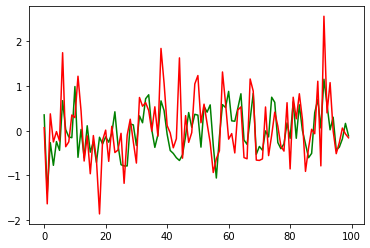

In [ ]:
Est = np.zeros((4,TLen))
Obs = np.zeros((4,TLen))

Est[:,0]     = Init  +np.random.multivariate_normal([0,0,0,0], CovMod)  #initial state with noise
Obs [:,0]    = Measurement(Init) + np.random.multivariate_normal([0,0,0,0] , CovMeas)

for k in range(1,TLen):

  Est[:,k]     = Model(Est[:,k-1])  + np.random.multivariate_normal([0,0,0,0], CovMod)  #update the hidden state
  Obs [:,k]    = Measurement(Est[:,k]) + np.random.multivariate_normal([0,0,0,0],CovMeas)  # measurments

#plt.plot(Est[0,:],Est[1,:],'g',Obs[0,:],Obs[1,:],'r')
plt.plot(Est[0,:],'g',Obs[0,:],'r')

## **Unscented Kálmán Filter**

Tajectory estimation

In [ ]:
def UKF(Model,Estimation,Covariance,Measurement,Obs,CovMod,CovMeas):
  Alpha  = 1e-3
  Ki     = 1
  Beta   = 2
  N      = len(Estimation)
  L      = 2*N+1
  Lambda = Alpha**2*(N + Ki) - N
  C      = N + Lambda    #scaling factor

  SigmaScal =np.sqrt(C)

  Wm  = np.zeros((2*N)+1)
  Wc   = np.zeros((2*N)+1)


  '''
  Alpha and Ki control the spread of the sigma points. Beta is related to the distribution of x (Estimatoin).
  Appropriate values depend on the problem at hand, but a typical recommendation is Alpha = 10i−3, Ki = 1, and Beta = 2.
  However, a larger value of Alpha = 1 may be beneficial in order to better capture the spread of the distribution and possible nonlinearities.
  If the true distribution of x is Gaussian, β = 2 is optimal. N is the number of dimensions


  SigmaPointsCal function to calculate the sigma points
  UnscentedTransformation function to applay the unscented transfomation
  '''


  """
  Task:

     1. calculate the weights for the expeted value(mean) and for the covariance:

                1. Wm(0) =  Lambda / (N + Lambda)
                2. Wc (0)  = Wm[0] + (1 - Alpha**2 + Beta)
                3. Wc(i) = Wm(i) = 1 / (2*(N + Lambda))  where i: 1 ----> 2*N+1

     2. calculate sigma points of our previous estimation  ----->  SigmaPoints

     3. applay Unscented transformation to the sigma points using the model function -----> ModelSigmaPoints, ModelEstimation , ModelCovariance, ModelDeviatoin

     4. calculate sigma points of our new model prediction  ----->  EstimatedModelSigmaPoints

     5. applay Unscented transformation to the sigma points with the measurement function to transfer our model predictoin to the measurement domain
                                                                                                -----> TranformedSigmaPoints, MeasEstimation , MeasCovariance, MeasDeviatoin
     6. Calculate the Cross-Covariance (P @ H from kalman filter):

          1. Calculate the deviation between the EstimatedModelSigmaPoints (Sigma points of the model after the estimation i.e. after unscented transformation)
             and the ModelEstimation (the expected value of our model).  ------> EstimatedModelDeviation    i.e. it is the deviation coming from P

          2. Multiply the EstimatedModelDeviation with MeasDeviatoin (deviation from transfering our model to the measurement domain i.e H)

          3. Use the Wc along side the multiplication from (2)

     8. Use Kalman filter equations to calculate:

                            1. Gain:  ((P @ H) @ (H @ P @ H.T + R)^-1

                                     1. P @ H is the cross-covariance
                                     2. (H @ P @ H.T + R) is the MeasCovariance i.e transfering the modelCovariance to the measurement doamin then adding the meausrement uncertainty

                            2. Estimation :  X + Gain @ (y  - H*X)

                                     1. X   : the model Estimation
                                     2. y   : the observation from our sensors
                                     3. H*X : the estimation after transfering the model estimation to the measurement domain

                            3. Covariance :  P - Gain @ H @ P  another valide equation P - Gain @ Pm @ Gain.T

                                     1. P     : the model covariance
                                     2. H @ P : Cross-Covariance transpose
                                     3. Pm    : the measurement covariance

  """
  Wm[0]  = Lambda / C
  Wc[0]  = Wm[0] + (1 - Alpha**2 + Beta)
  for i in range(1,len(Wm)):
    Wm[i] = 1. / (2.*C)
    Wc[i] = 1. / (2.*C)

  SigmaEstimation      = SigmaPointsCal(Estimation       ,Covariance      ,SigmaScal)
  ModelTranformedSigmaEstimation, ModelEstimation , ModelCovariance, ModelDeviation  = UnscentedTransformation(Model         ,SigmaEstimation     , Wm, Wc, CovMod )


  ModelSigmaEstimation = SigmaPointsCal(ModelEstimation  , ModelCovariance ,SigmaScal)
  MeasTranformedSigmaEstimation,  MeasEstimation ,  MeasCovariance, MeasDeviation    = UnscentedTransformation(Measurement   ,ModelSigmaEstimation, Wm, Wc, CovMeas)

  EstimatedModelDeviation = (ModelSigmaEstimation.T - ModelEstimation).T

  #CrossCovariance = (np.tile(Wc,(N,1))*EstimatedModelDeviation ) @ MeasDeviation.T
  CrossCovariance = EstimatedModelDeviation @ np.diag(Wc) @ MeasDeviation.T

  Gain = CrossCovariance @ np.linalg.inv(MeasCovariance)  #

  Estimation = ModelEstimation + Gain @ (Obs - MeasEstimation)

  Covariance = ModelCovariance - Gain @ CrossCovariance.T

  return Estimation, Covariance

def SigmaPointsCal(Estimation, Covariance, Scal):

  N = len(Estimation)                    # dimension of our model
  SigmaPoints = np.zeros((N, (2*N)+1))   # 2*N + 1 points with N dimension each

  """
  Tasks:

   1. calculate the variance using cholesky transformation of the Covariance i.e. Eigenvalues of the covariance ----> variance

                Note: it is very important to realize that the eigenvalues in the variance matrix are in the rows

   2. Scale the variance

   3. calculate the sigmapoints (P):

         1. P(0)      : Estimation i.e. the expected value
         2. P(1  :N+1): Estimation + variance
         3. P(N+1:2N ): Estimation - variance

  """
  SigmaPoints[:,0] = Estimation
  Vectors = Scal * np.l inalg.cholesky(Covariance)
  SigmaPoints[:,1:N+1] = (Estimation + Vectors.T).T
  SigmaPoints[:,N+1:] = (Estimation - Vectors.T).T
  return SigmaPoints


def UnscentedTransformation(Function, SigmaPoints, Wm, Wc, CovNoise):

  N = np.shape(SigmaPoints)[0] # dimention of our model
  L = np.shape(SigmaPoints)[1] # number of sigma points which is 2*N + 1

  Mean        = np.zeros(N)
  TransformedSigmaPoints = np.zeros_like(SigmaPoints)

  """
  Tasks:

    1. Applay the Function to the SigmaPoints i.e  transition to the next state------>  TransformedSigmaPoints
    2. calculate the mean: Sum(X(i)*Wm[i]) BTW X is SigmaPoints -----> Mean
    3. calculate the deviation: X - Mean  -----> Deviation
    4. calculate the covariance:  Deviation @ Wc @ Deviation.T + CovNoise -----> Covariance
             Note that Wc here is a matrix wich contains the vlaues of the original Wc in the diameter

  """
  for i in range(L):
         TransformedSigmaPoints[:,i] = Function(SigmaPoints[:,i])
         Mean +=  TransformedSigmaPoints[:,i] * Wm[i]
  Deviation = (TransformedSigmaPoints.T -Mean).T
  Covariance = Deviation @ np.diag(Wc) @ Deviation.T + CovNoise

  return  TransformedSigmaPoints,  Mean , Covariance, Deviation


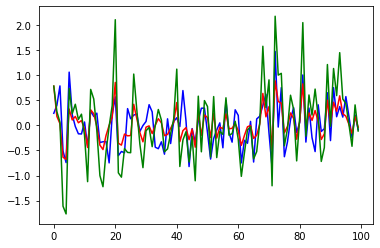

In [ ]:
#tragectory length
TLen = 100
N = 4
#In each step we have four variables (X , Y, X', Y') i.e (postion x, postion y, speed x, speed y)
Model_Est = np.zeros((4,TLen))
UKF_Est = np.zeros((4,TLen))
Obs = np.zeros((4,TLen))

#Initial values for (X , Y, X', Y')
Init = np.array([0.6,0.2,2,0.75])



Est[:,0]     = Init  +np.random.multivariate_normal([0,0,0,0], CovMod)    #initial state with noise
Obs [:,0]    = Measurement(Init) + np.random.multivariate_normal([0,0,0,0], CovMeas)
UKF_Est[:,0] = Obs [:,0]

P = np.eye(N) # initial state covraiance
x = UKF_Est[:,0]

for k in range(1,TLen):
  Est[:,k]     = Model(Est[:,k-1]) +np.random.multivariate_normal([0,0,0,0], CovMod)   #update the hidden state
  Obs [:,k]    = Measurement(Est[:,k])  + np.random.multivariate_normal([0,0,0,0], CovMeas)    # measurments
  x, P         = UKF(Model,x,P,Measurement,Obs[:,k],CovMod,CovMeas)            # ukf
  UKF_Est[:,k] = x

plt.plot(Est[0,:],'b',UKF_Est[0,:],'r',Obs[0,:],'g')

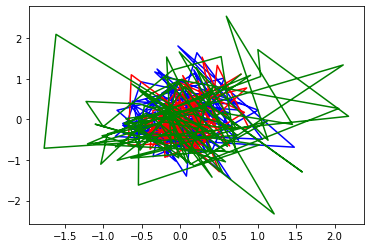

In [ ]:
plt.plot(Est[0,:],Est[1,:],'b')
plt.plot(UKF_Est[0,:],UKF_Est[1,:],'r')
plt.plot(Obs[0,:],Obs[1,:],'g')